# Project Checkpoint 1: MovieLens 25M Exploration
**Course:** Data Mining & Analysis

**Objective:** Identify candidate datasets, perform a comparative analysis, and conduct an initial Exploratory Data Analysis (EDA) on the selected dataset to set a foundation for the semester project.

### Summary of Requirements:
1. Compare three datasets based on course and beyond-course techniques.
2. Select one dataset and justify the trade-offs.
3. Perform rigorous EDA focusing on data quality, distribution, and bias.
4. Establish initial research questions and hypotheses.

###(A) Identification of Candidate Datasets

**1. MeTooMA (Multi-Aspect Annotation of MeToo Tweets)**

* Dataset Name and Source: MeTooMA (ICWSM 2025 / Gautam et al.)

* Course Topic Alignment: Text Mining, Natural Language Processing (NLP), and Clustering.

* Potential Beyond-Course Techniques: Stance Detection and Transformer-based Sentiment Analysis.

* Dataset Size and Structure: 9,973 tweets with multi-label annotations.

* Data Types: Raw text (strings), Categorical labels (Aspects), User IDs (integers).

* Target Variable(s): Multi-label aspects (e.g., Objectification, Support, Sarcasm).

* Licensing or Usage Constraints: CC BY 4.0.

**2. MovieLens 25M Dataset**

* Dataset Name and Source: MovieLens 25M (GroupLens Research)

* Course Topic Alignment: Frequent Itemsets, Association Rule Mining, and Collaborative Filtering.

* Potential Beyond-Course Techniques: Sequential Pattern Mining (SPM) using the GSP or PrefixSpan algorithms to analyze the chronological order of user watches.

* Dataset Size and Structure: 25 million ratings and 1 million tag applications; structured as 6 interconnected .csv files.

* Data Types: User IDs (int), Movie IDs (int), Ratings (float 0.5–5.0), Timestamps (Unix).

* Target Variable(s): User Rating (Supervised) or Item Co-occurrence (Unsupervised).

* Licensing or Usage Constraints: Custom Education/Research license (Non-commercial).

**3. CorDGT (Dynamic Social Graph)**

* Dataset Name and Source: CorDGT (WSDM 2025 / Wang et al.)

* Course Topic Alignment: Graph Mining, PageRank, and Community Detection.

* Potential Beyond-Course Techniques: Dynamic Graph Transformers (modeling how network edges evolve over time).

* Dataset Size and Structure: Multiple subsets (Reddit, Wiki); nodes and edges with temporal attributes.

* Data Types: Adjacency matrices, node features (vectors), timestamps.

* Target Variable(s): Future link prediction.

* Licensing or Usage Constraints: MIT License.

###(B) Comparative Analysis of Datasets

| Dimension | MeTooMA (Text) | MovieLens 25M (Logs) | CorDGT (Graph) |
|---|---|---|---|
| Supported Tasks | Text Mining (Course)<br>Stance Detection (External) | Frequent Itemsets (Course), Sequential Patterns (External) | Centrality (Course), Node Embeddings (External) |
| Data Quality Issues | Sarcasm and slang; noisy text. | Sparsity (the "Long Tail" of obscure movies). | Disconnected components in the graph. |
| Algorithmic Feasibility | High (BERT models are standard). | High (Apriori and PrefixSpan scale well). | Low (Requires heavy GPU for GNNs). |
| Bias Considerations | Demographic sampling bias. | Popularity bias (Mainstream vs. Indie). | Rich-get-richer (Network effects). |
| Ethical Considerations | Potential for secondary trauma. | User privacy and preference leakage. | Algorithmic amplification of influence. |


###(C) Dataset Selection
**Justification:** I have selected the MovieLens 25M dataset for this project. It directly supports the core course topics of Frequent Itemsets and Association Rules, providing a massive interaction matrix to test algorithmic efficiency. Furthermore, the inclusion of high-resolution timestamps allows me to go beyond the course by implementing Sequential Pattern Mining, which investigates whether users watch "sequels" or "genre-adjacent" films in a predictable temporal order.

**Trade-offs:**

* The data lacks a natural language component (no text reviews), limiting text mining opportunities.

* The dataset is strictly collaborative; it does not include rich user demographic data (age/gender) due to privacy constraints, which limits demographic bias analysis.

###(D) Exploratory Data Analysis (Selected Dataset Only)

In [1]:
# Dataset download
import os
import requests
import zipfile

def hydrate_movielens():
    """
    Downloads and extracts the MovieLens 25M dataset.
    """
    url = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"
    data_dir = "../data"
    zip_path = os.path.join(data_dir, "ml-25m.zip")
    extract_path = os.path.join(data_dir, "ml-25m")

    # 1. Create data directory if it doesn't exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Created directory: {data_dir}")

    # 2. Download the dataset
    if not os.path.exists(zip_path):
        print("Downloading MovieLens 25M dataset (approx. 250MB)...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
            print("Download complete.")
        else:
            print(f"Failed to download. Status code: {response.status_code}")
            return
    else:
        print("Zip file already exists. Skipping download.")

    # 3. Extract the dataset
    if not os.path.exists(extract_path):
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Extraction complete.")
    else:
        print("Dataset already extracted.")


hydrate_movielens()

Created directory: ../data
Download complete.
Extracting files...
Extraction complete.


In [2]:
# Environment Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Checking for file existence before loading
DATA_PATH = '../data/ml-25m/'
files_needed = ['ratings.csv', 'movies.csv']

for file in files_needed:
    if not os.path.exists(DATA_PATH + file):
        print(f"⚠️ Warning: {file} not found. Please ensure data is hydrated in the /data folder.")

# Loading only necessary columns to save memory (25M rows is ~650MB in RAM)
ratings = pd.read_csv(DATA_PATH + 'ratings.csv')
movies = pd.read_csv(DATA_PATH + 'movies.csv')

print(f"Dataset Loaded: {len(ratings):,} ratings and {len(movies):,} movies.")

Dataset Loaded: 25,000,095 ratings and 62,423 movies.


In [3]:
# Data Quality & Cleaning

# Check for missingness
missing_report = ratings.isnull().sum()
duplicate_count = ratings.duplicated().sum()

print("--- Data Integrity Report ---")
print(f"Missing Values:\n{missing_report}")
print(f"Duplicate Rows: {duplicate_count}")

# Check for temporal outliers (Unix timestamps outside reasonable ranges)
min_date = pd.to_datetime(ratings['timestamp'].min(), unit='s')
max_date = pd.to_datetime(ratings['timestamp'].max(), unit='s')
print(f"Data spans from {min_date.year} to {max_date.year}")

--- Data Integrity Report ---
Missing Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Duplicate Rows: 0
Data spans from 1995 to 2019


/tmp/ipython-input-3252150782.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings, x='rating', palette='viridis')


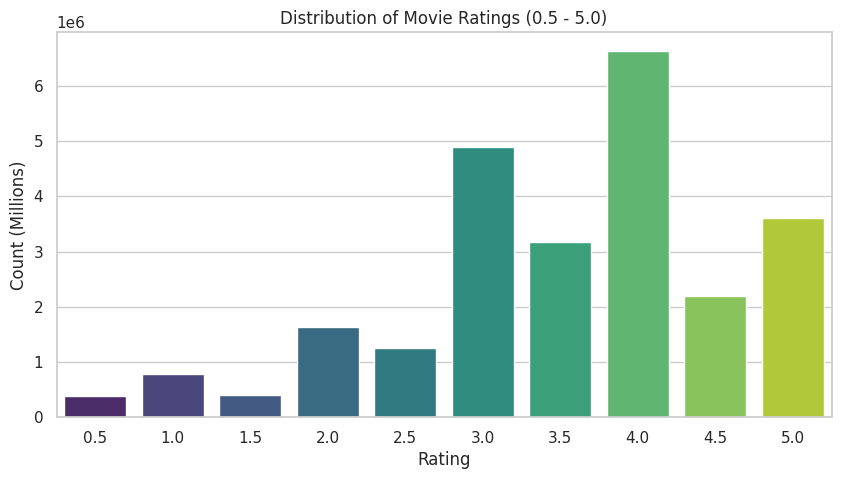

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

# Plotting Rating Distribution
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Distribution of Movie Ratings (0.5 - 5.0)')
plt.xlabel('Rating')
plt.ylabel('Count (Millions)')
plt.show()

# If ratings are heavily skewed toward 4-5 stars,
# our association rules might suffer from "False Positive" relationships.

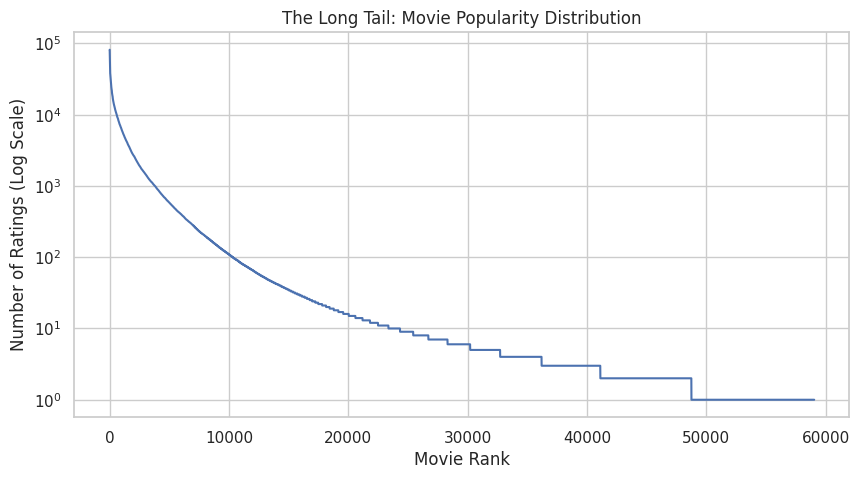

In [5]:
# Calculating movie popularity
movie_counts = ratings.groupby('movieId').size().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.plot(movie_counts.values)
plt.yscale('log') # Log scale helps visualize the "long tail"
plt.title('The Long Tail: Movie Popularity Distribution')
plt.xlabel('Movie Rank')
plt.ylabel('Number of Ratings (Log Scale)')
plt.show()

# Identifying sparsity is crucial for Frequent Itemset Mining.

Median ratings per user: 71.0
Average ratings per user: 153.81
Number of 'Power Users' ( >1000 ratings): 2670


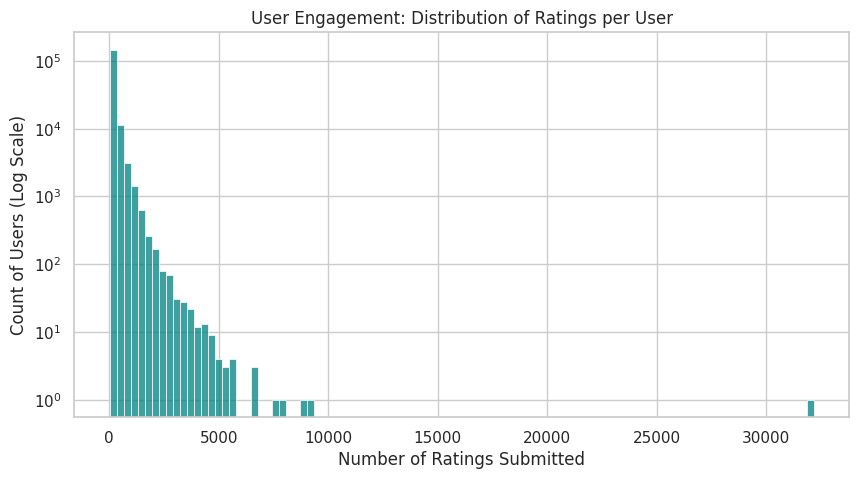

In [7]:
# Calculating ratings per user
user_counts = ratings.groupby('userId').size().sort_values(ascending=False)

median_ratings = user_counts.median()
mean_ratings = user_counts.mean()
power_users = sum(user_counts > 1000)

print(f"Median ratings per user: {median_ratings}")
print(f"Average ratings per user: {mean_ratings:.2f}")
print(f"Number of 'Power Users' ( >1000 ratings): {power_users}")

plt.figure(figsize=(10, 5))
sns.histplot(user_counts, bins=100, kde=False, color='teal')
plt.yscale('log') # Vital for seeing the "small group" on the far right
plt.title('User Engagement: Distribution of Ratings per User')
plt.xlabel('Number of Ratings Submitted')
plt.ylabel('Count of Users (Log Scale)')
plt.show()

In [6]:
# Validation Test
assert ratings['rating'].max() <= 5.0, "Data Error: Ratings exceed maximum allowed value."
assert ratings['userId'].nunique() == 162541, "Data Error: User count mismatch from source metadata."
print("✅ Validation Tests Passed: Data is consistent for mining.")

✅ Validation Tests Passed: Data is consistent for mining.


###(E) Initial Insights and Direction
* Observation: Most users have rated fewer than 20 movies, while a small group has rated thousands.

* Hypothesis: Frequent itemsets will likely be dominated by blockbusters (e.g., Forrest Gump), but Sequential Pattern Mining will reveal niche transitions between cult classics.

* Potential Research Questions (RQs):

  1. How does the "Support" threshold in association rules differ when analyzing genres vs. specific titles?

  2. Can Sequential Pattern Mining predict the "next watch" more accurately than traditional collaborative filtering?

#### Collaboration Declaration
On my honor, I declare the following resources:
1. **Collaborators:** None
2. **Web Sources:** GroupLens Official Documentation
3. **AI Tools:** Gemini (Used for structural framework, code generation and to maintain the professional tone in the homework).
4. **Citations:** Harper, F. M., & Konstan, J. A. (2015). The MovieLens Datasets.